In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [234]:
import numpy as np
import pandas as pd
import util.common as util

# Load Data

In [119]:
clean_dir = "/project/data/cicids2017/clean/"
x_binary_train, y_binary_train, x_binary_val, y_binary_val, x_binary_test, y_binary_test, x_multi_train, y_multi_train, x_multi_test, y_multi_test = util.load_data(clean_dir, sample_size=1948, val_size=129485)

(D)DOS          321637
Port Scan        90694
Brute Force       9150
Web Attack        2143
Botnet            1948
Infiltration        36
Heartbleed          11
Name: Label, dtype: int64
Attack type:    #Original:     #Sampled:      #Train:       #Test:
      (D)DOS        321637          1948         1363          585
      Botnet          1948          1948         1363          585
 Brute Force          9150          1948         1363          585
  Heartbleed            11            11            0           11
Infiltration            36            36            0           36
   Port Scan         90694          1948         1363          585
  Web Attack          2143          1948         1363          585


In [114]:
np.unique(y_binary_train, return_counts=True)

(array([1.]), array([100000]))

In [120]:
np.unique(y_binary_val, return_counts=True)

(array([-1.,  1.]), array([  6815, 129485]))

In [108]:
np.unique(y_binary_test, return_counts=True)

(array([-1.,  1.]), array([ 2972, 30000]))

## Normalise data

In [121]:
from sklearn.preprocessing import QuantileTransformer

binary_scaler = QuantileTransformer(output_distribution='normal')
x_binary_train_s = binary_scaler.fit_transform(x_binary_train)
x_binary_val_s = binary_scaler.transform(x_binary_val)
x_binary_test_s = binary_scaler.transform(x_binary_test)

In [33]:
# from sklearn.preprocessing import MinMaxScaler

# binary_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
# x_binary_train_s = binary_scaler.fit_transform(x_binary_train)
# x_binary_val_s = binary_scaler.transform(x_binary_val)
# x_binary_test_s = binary_scaler.transform(x_binary_test)

# Train Model

In [110]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l2

def create_model(params):
    input_layer = Input(shape=(params["input_dimension"],))
    model = input_layer
    
    # Encoder
    for n in params["n_neurons"]:
        model = Dense(n, activation=params['hidden_activation'], activity_regularizer=l2(params["l2_reg"]))(model)

    # Decoder - Do not repeat encoded layer
    for n in reversed(params["n_neurons"][:-1]):
        model = Dense(n, activation=params['hidden_activation'], activity_regularizer=l2(params["l2_reg"]))(model)

    # Output Layer
    model = Dense(params["input_dimension"], activation=params['output_activation'], activity_regularizer=l2(params["l2_reg"]))(model)
    autoencoder = Model(inputs=input_layer, outputs=model)
    autoencoder.compile(optimizer=params['optimizer'], loss=params['loss'])
    return autoencoder

In [10]:
params = {
#     "scaler": "quantile", # "minmax"
    "output_activation": "linear", # "sigmoid",
    "hidden_activation": "relu",
    "optimizer": "adam",
    "loss": "mean_squared_error",
    "input_dimension": 67,
    "n_layers": 3,
    "n_neurons": [63, 61, 58],
    "l2_reg": 1.120192e-06
}

In [13]:
autoencoder = create_model(params)
history = autoencoder.fit(
    x_binary_train_s,
    x_binary_train_s,
    epochs=7, 
    shuffle=True,
    verbose=1
)
# trial.set_user_attr('epochs', len(history.history['loss']))
# trial.set_user_attr('losses', history.history['loss'])
x_val_autoencoder = autoencoder.predict(x_binary_val_s)
val_score = util.anomaly_scores(x_binary_val_s, x_val_autoencoder)
val_metrics = util.evaluate_results(y_binary_val, val_score)
val_metrics

Epoch 1/7
3125/3125 [==============================] - 6s 2ms/step - loss: 0.8637
Epoch 2/7
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0505
Epoch 3/7
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0339
Epoch 4/7
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0266
Epoch 5/7
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0220
Epoch 6/7
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0194
Epoch 7/7
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0177


/project/Two-Stage/util/common.py:99: RuntimeWarning: invalid value encountered in true_divide
  results["f1"] = 2*precision*recall/(precision+recall)
/project/Two-Stage/util/common.py:100: RuntimeWarning: invalid value encountered in true_divide
  results["f2"] = 5*precision*recall/(4*precision+recall)


f1                   precision    0.318512
                     recall       0.566544
                     f1           0.407773
                     f2           0.490199
f2                   precision    0.314761
                     recall       0.571974
                     f1           0.406063
                     f2           0.491625
f1threshold                       1.711022
f2threshold                       1.674318
au_precision_recall               0.240969
auroc                             0.812038
dtype: float64

In [14]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 67)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 63)                4284      
_________________________________________________________________
dense_7 (Dense)              (None, 61)                3904      
_________________________________________________________________
dense_8 (Dense)              (None, 58)                3596      
_________________________________________________________________
dense_9 (Dense)              (None, 61)                3599      
_________________________________________________________________
dense_10 (Dense)             (None, 63)                3906      
_________________________________________________________________
dense_11 (Dense)             (None, 67)                4288

In [168]:
from tensorflow import keras
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

def test_saved_model(path, x, y, min_recall=0.10):
    model = keras.models.load_model(path)
    print(model.summary())
    x_predict = model.predict(x)
    score = util.anomaly_scores(x, x_predict)
    metrics = util.evaluate_results(y, score)
    print(metrics)
    precision, recall, threshold = precision_recall_curve(y, score, pos_label=-1)
    results = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': np.append(threshold, np.inf)})
    best_index_fscore = {}
    for i in range(1, 10):
        results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
        best_index_fscore[f"F{i}"] = results[f"F{i}"].idxmax()
#         results["f1"] = 2*precision*recall/(precision+recall)
#         results["f2"] = 5*precision*recall/(4*precision+recall)
#         max_index_f1 = results["f1"].idxmax()
#         max_index_f2 = results["f2"].idxmax()
    
    length = sum(recall > min_recall)
    plt.plot(threshold[:length], results['precision'][:length], label="precision", color="silver")
    plt.plot(threshold[:length], results['recall'][:length], label="recall", color="black")
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
    fscores = []
    for i in range(1, 10):
        best_index = best_index_fscore[f'F{i}']
        fscores.append({
            "metric": f"F{i}", 
            "value": str(round(results[f'F{i}'][best_index], 4)), 
            "threshold": threshold[best_index],
            "precision": str(round(results["precision"][best_index], 4)),
            "recall": str(round(results["recall"][best_index], 4)),
            "BNG next stage": (score[(y == 1)] >= threshold[best_index]).sum() / (y == 1).sum()
        })
        plt.plot(threshold[:length], results[f"F{i}"][:length], label=f"F{i}: {fscores[-1]['value']}", color=colors[i-1])
        plt.plot(float(fscores[-1]["threshold"]), float(fscores[-1]["value"]), marker="X", color=colors[i-1])
#         plt.annotate(f"F{i}: {str(round(results[f'f{i}'][best_index_fscore[f'f{i}']], 2))}", (threshold[best_index_fscore[f"f{i}"]], results[f"f{i}"][best_index_fscore[f"f{i}"]]))
#     plt.plot(threshold[:length], results['f2'][:length], label="F2")
#     plt.plot(threshold[max_index_f2], results["f2"][max_index_f2], marker="X", color="#2ca02c")
#     plt.plot(threshold[:length], results['f1'][:length], label="F1")
#     plt.plot(threshold[max_index_f1], results["f1"][max_index_f1], marker="X", color="#d62728")
#     plt.annotate(f"F1: {str(round(results['f1'][max_index_f1], 2))}", (threshold[max_index_f1], results["f1"][max_index_f1]))
#     plt.annotate(f"F2: {str(round(results['f2'][max_index_f2], 2))}", (threshold[max_index_f2], results["f2"][max_index_f2]))
    plt.xlabel(r"threshold ($\tau_B$)")
    plt.ylabel("score")
    plt.legend()
    print(pd.DataFrame(fscores))
    return score, pd.DataFrame(fscores), results

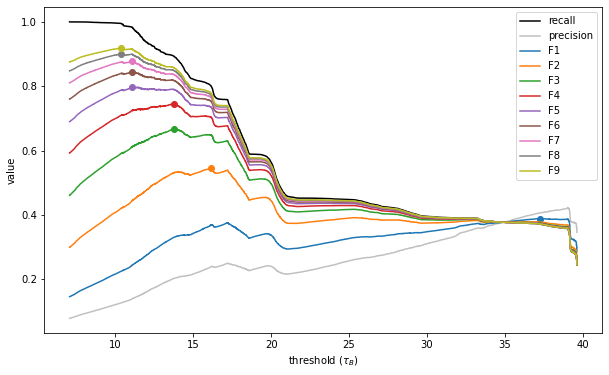

In [238]:
fig = util.plot_fscores(test2, test1, show_thresholds=False)

In [241]:
for index, row in test1.iterrows():
    print(row['metric'], row['value'])

F1 0.3884
F2 0.5455
F3 0.6667
F4 0.7445
F5 0.798
F6 0.8454
F7 0.8774
F8 0.9006
F9 0.9187


In [171]:
test2

,precision,recall,threshold,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,0.078677,1.000000,7.055987,0.145877,0.299218,0.460613,0.592124,0.689469,0.759595,0.810239,0.847345,0.875038
1,0.078666,0.999853,7.056030,0.145857,0.299177,0.460549,0.592040,0.689370,0.759485,0.810122,0.847222,0.874911
2,0.078667,0.999853,7.056065,0.145859,0.299180,0.460552,0.592043,0.689373,0.759488,0.810124,0.847224,0.874913
3,0.078668,0.999853,7.056083,0.145860,0.299182,0.460555,0.592046,0.689376,0.759490,0.810126,0.847225,0.874914
4,0.078669,0.999853,7.056282,0.145862,0.299185,0.460558,0.592049,0.689378,0.759492,0.810128,0.847227,0.874915
...,...,...,...,...,...,...,...,...,...,...,...,...
81396,0.000000,0.000000,322.864937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81397,0.000000,0.000000,379.758138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81398,0.000000,0.000000,471.154483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81399,0.000000,0.000000,566.963790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Model: "model_305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_306 (InputLayer)       [(None, 67)]              0         
_________________________________________________________________
dense_1322 (Dense)           (None, 66)                4488      
_________________________________________________________________
dense_1323 (Dense)           (None, 63)                4221      
_________________________________________________________________
dense_1324 (Dense)           (None, 66)                4224      
_________________________________________________________________
dense_1325 (Dense)           (None, 67)                4489      
Total params: 17,422
Trainable params: 17,422
Non-trainable params: 0
_________________________________________________________________
None


/project/Two-Stage/util/common.py:109: RuntimeWarning: invalid value encountered in true_divide
  return best
/project/Two-Stage/util/common.py:110: RuntimeWarning: invalid value encountered in true_divide
  
<ipython-input-168-4e544f0e8ac9>:16: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)


f1                   precision     0.406777
                     recall        0.371680
                     f1            0.388437
                     f2            0.378206
f2                   precision     0.239591
                     recall        0.801321
                     f1            0.368887
                     f2            0.545522
f1threshold                       37.285768
f2threshold                       16.140622
au_precision_recall                0.267528
auroc                              0.907343
dtype: float64
  metric   value  threshold precision  recall  BNG next stage
0     F1  0.3884  37.285768    0.4068  0.3717        0.028528
1     F2  0.5455  16.140622    0.2396  0.8013        0.133853
2     F3  0.6667  13.750668    0.2029  0.8936        0.184755
3     F4  0.7445  13.750668    0.2029  0.8936        0.184755
4     F5   0.798  11.087596    0.1398  0.9833        0.318531
5     F6  0.8454  11.087596    0.1398  0.9833        0.318531
6     F7  0.8774  11.08

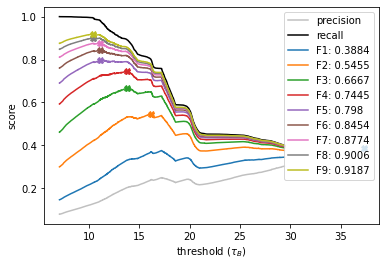

In [169]:
study_name = "TWOS-37"
trial_number = 1223
path = f'results/binary/autoencoder/{study_name}/models/model_{trial_number}.h5'
y_proba, test1, test2 = test_saved_model(path, x_binary_val_s, y_binary_val, min_recall=0.4)

Model: "model_305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_306 (InputLayer)       [(None, 67)]              0         
_________________________________________________________________
dense_1322 (Dense)           (None, 66)                4488      
_________________________________________________________________
dense_1323 (Dense)           (None, 63)                4221      
_________________________________________________________________
dense_1324 (Dense)           (None, 66)                4224      
_________________________________________________________________
dense_1325 (Dense)           (None, 67)                4489      
Total params: 17,422
Trainable params: 17,422
Non-trainable params: 0
_________________________________________________________________
None


/project/Two-Stage/util/common.py:99: RuntimeWarning: invalid value encountered in true_divide
  results["f1"] = 2*precision*recall/(precision+recall)
/project/Two-Stage/util/common.py:100: RuntimeWarning: invalid value encountered in true_divide
  results["f2"] = 5*precision*recall/(4*precision+recall)
<ipython-input-100-e2ed339d3308>:16: RuntimeWarning: invalid value encountered in true_divide
  results[f"f{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)


f1                   precision     0.301306
                     recall        0.758327
                     f1            0.431260
                     f2            0.581825
f2                   precision     0.289229
                     recall        0.802201
                     f1            0.425166
                     f2            0.592154
f1threshold                       17.202333
f2threshold                       16.121394
au_precision_recall                0.318724
auroc                              0.907273
dtype: float64
  metric   value  threshold precision  recall  BNG next stage
0     F1  0.4313  17.202333    0.3013  0.7583         0.11984
1     F2  0.5922  16.121394    0.2892  0.8022         0.13435
2     F3  0.7088  13.750668    0.2477  0.8936         0.18495
3     F4   0.775  13.676030    0.2459  0.8954         0.18715
4     F5  0.8343  11.087596    0.1743  0.9833         0.31744
5     F6  0.8737  11.087596    0.1743  0.9833         0.31744
6     F7  0.9005  10.38

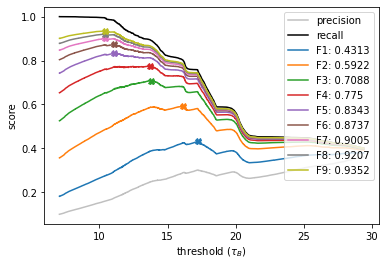

In [101]:
study_name = "TWOS-37"
trial_number = 1223
path = f'results/binary/autoencoder/{study_name}/models/model_{trial_number}.h5'
y_proba = test_saved_model(path, x_binary_val_s, y_binary_val, min_recall=0.4)

Model: "model_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_269 (InputLayer)       [(None, 67)]              0         
_________________________________________________________________
dense_1130 (Dense)           (None, 59)                4012      
_________________________________________________________________
dense_1131 (Dense)           (None, 58)                3480      
_________________________________________________________________
dense_1132 (Dense)           (None, 59)                3481      
_________________________________________________________________
dense_1133 (Dense)           (None, 67)                4020      
Total params: 14,993
Trainable params: 14,993
Non-trainable params: 0
_________________________________________________________________
None


/project/Two-Stage/util/common.py:99: RuntimeWarning: invalid value encountered in true_divide
  results["f1"] = 2*precision*recall/(precision+recall)
/project/Two-Stage/util/common.py:100: RuntimeWarning: invalid value encountered in true_divide
  results["f2"] = 5*precision*recall/(4*precision+recall)
<ipython-input-100-e2ed339d3308>:16: RuntimeWarning: invalid value encountered in true_divide
  results[f"f{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)


f1                   precision    0.511219
                     recall       0.682025
                     f1           0.584397
                     f2           0.639305
f2                   precision    0.432199
                     recall       0.749230
                     f1           0.548178
                     f2           0.653376
f1threshold                       1.155062
f2threshold                       0.954571
au_precision_recall               0.428301
auroc                             0.882656
dtype: float64
  metric   value  threshold precision  recall  BNG next stage
0     F1  0.5844   1.155062    0.5112   0.682         0.04444
1     F2  0.6534   0.954571    0.4322  0.7492         0.06708
2     F3   0.723   0.713679    0.3459  0.8226         0.10602
3     F4   0.761   0.712783    0.3452  0.8229         0.10637
4     F5  0.7813   0.712783    0.3452  0.8229         0.10637
5     F6  0.8102   0.366995    0.1713  0.9039         0.29798
6     F7  0.8328   0.365655    0.17

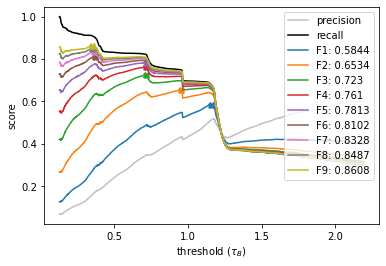

In [103]:
study_name = "TWOS-37"
trial_number = 1104
path = f'results/binary/autoencoder/{study_name}/models/model_{trial_number}.h5'
y_proba = test_saved_model(path, x_binary_val_s, y_binary_val, min_recall=0.3)

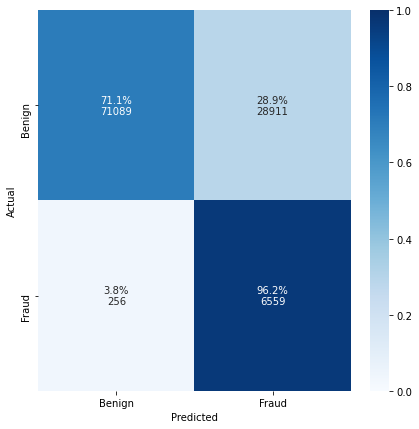

In [63]:
threshold = 11.5
y_pred = np.where(y_proba > threshold, -1, 1)
fig = util.plot_confusion_matrix(y_binary_val, y_pred, values=[1, -1], labels=["Benign", "Fraud"])

In [15]:
import neptune
neptune.init(project_qualified_name='verkerken/two-stage-binary', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMGJlYTgzNzEtM2U3YS00ODI5LWEzMzgtM2M0MjcyMDIxOWUwIn0=')

Project(verkerken/two-stage-binary)

In [16]:
neptune.create_experiment('hello-world-ae', tags=["autoencoder", "cicids2017", "binary"])

https://ui.neptune.ai/verkerken/two-stage-binary/e/TWOS-2


Experiment(TWOS-2)

In [18]:
from sklearn.metrics import roc_auc_score

roc_auc_score(-y_binary_val, val_score)

0.735831134262656

In [24]:
str(val_metrics.to_dict())

"{'precision': 0.12859438430311232, 'recall': 0.8924431401320616, 'f1': 0.22479717617489975, 'threshold': 0.0027857437069087783, 'au_precision_recall': 0.21537287814713807, 'auroc': 0.7504856258253851}"

In [57]:
import os


In [62]:
import pathlib
pathlib.Path('results/binary/autoencoder/TWOS-3').mkdir(parents=True, exist_ok=True)

In [71]:
import optuna
study_storage = '/project/Two-Stage/results/binary/autoencoder.db'
study = optuna.create_study(
    study_name="test", 
    direction='maximize', 
    storage=f'sqlite:///{study_storage}',
    load_if_exists=True
)

[I 2021-03-02 00:08:38,990] Using an existing study with name 'test' instead of creating a new one.


In [76]:
val_metrics = util.evaluate_results(y_binary_val, val_score)
val_metrics

/project/Two-Stage/util/common.py:97: RuntimeWarning: invalid value encountered in true_divide
  results["f1"] = 2*precision*recall/(precision+recall)
/project/Two-Stage/util/common.py:98: RuntimeWarning: invalid value encountered in true_divide
  max_index = results["f1"].idxmax()


f1                   precision    0.128594
                     recall       0.892443
                     f1           0.224797
                     f2           0.407881
f2                   precision    0.128546
                     recall       0.893617
                     f1           0.224761
                     f2           0.407980
threshold                         0.002786
au_precision_recall               0.215373
auroc                             0.750486
dtype: float64

In [81]:
val_metrics.index = val_metrics.index.map(''.join)
val_metrics

f1precision            0.128594
f1recall               0.892443
f1f1                   0.224797
f1f2                   0.407881
f2precision            0.128546
f2recall               0.893617
f2f1                   0.224761
f2f2                   0.407980
threshold              0.002786
au_precision_recall    0.215373
auroc                  0.750486
dtype: float64

In [82]:
val_metrics.to_dict()

{'f1precision': 0.12859438430311232,
 'f1recall': 0.8924431401320616,
 'f1f1': 0.22479717617489975,
 'f1f2': 0.4078813241053705,
 'f2precision': 0.12854609929078015,
 'f2recall': 0.8936170212765957,
 'f2f1': 0.22476056909818976,
 'f2f2': 0.40798006324025937,
 'threshold': 0.0027857437069087783,
 'au_precision_recall': 0.21537287814713807,
 'auroc': 0.7504856258253851}

In [87]:
for k,v in val_metrics.to_dict().items():
    print(k)
    print(v)

f1precision
0.12859438430311232
f1recall
0.8924431401320616
f1f1
0.22479717617489975
f1f2
0.4078813241053705
f2precision
0.12854609929078015
f2recall
0.8936170212765957
f2f1
0.22476056909818976
f2f2
0.40798006324025937
threshold
0.0027857437069087783
au_precision_recall
0.21537287814713807
auroc
0.7504856258253851


In [29]:
def create_model(params):
    input_layer = Input(shape=(params["input_dimension"],))
    model = input_layer
    
    # Encoder
    for n in params["n_neurons"]:
        model = Dense(n, activation=params['hidden_activation'], activity_regularizer=l2(params["l2_reg"]))(model)

    # Decoder - Do not repeat encoded layer
    for n in reversed(params["n_neurons"][:-1]):
        model = Dense(n, activation=params['hidden_activation'], activity_regularizer=l2(params["l2_reg"]))(model)

    # Output Layer
    model = Dense(params["input_dimension"], activation=params['output_activation'], activity_regularizer=l2(params["l2_reg"]))(model)
    autoencoder = Model(inputs=input_layer, outputs=model)
    autoencoder.compile(optimizer=params['optimizer'], loss=params['loss'])
    return autoencoder

In [26]:
params = {'scaler': 'quantile', 'output_activation': 'linear', 'hidden_activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'input_dimension': 67, 'n_layers': 1, 'n_neurons': [62, 27, 5], 'l2_reg': 1.6664447908824294e-10}

In [27]:
m = create_model(params)

In [8]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l2

In [28]:
m.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 67)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 62)                4216      
_________________________________________________________________
dense_22 (Dense)             (None, 27)                1701      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 140       
_________________________________________________________________
dense_24 (Dense)             (None, 27)                162       
_________________________________________________________________
dense_25 (Dense)             (None, 62)                1736      
_________________________________________________________________
dense_26 (Dense)             (None, 67)                4221

# Log Final results to disk and neptune

In [1]:
import optuna

In [40]:
study_storage = 'results/binary/autoencoder_linear_cpu.db'
# study_storage = 'results/binary/autoencoder_linear_gpu.db'
# study_storage = 'results/binary/autoencoder_sigmoid.db'
study_storage = 'results/binary/ocsvm.db'

In [42]:
list(map(lambda s: s.study_name, optuna.study.get_all_study_summaries(storage=f"sqlite:///{study_storage}")))

['TWOS-47',
 'TWOS-48',
 'TWOS-49',
 'TWOS-50',
 'TWOS-51',
 'TWOS-52',
 'TWOS-53',
 'TWOS-54',
 'TWOS-55']

In [45]:
study_name = "TWOS-55"
save_dir = f'results/binary/autoencoder/{study_name}'

In [46]:
study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_storage}")
results = study.trials_dataframe()
results.sort_values(by=['value'], inplace=True, ascending=False)
# results.to_csv(f'{save_dir}/result.csv')
results.head()

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_n_comp,params_nu,params_scaler,user_attrs_au_precision_recall,...,user_attrs_f1f2,user_attrs_f1precision,user_attrs_f1recall,user_attrs_f1threshold,user_attrs_f2f1,user_attrs_f2f2,user_attrs_f2precision,user_attrs_f2recall,user_attrs_f2threshold,state
1067,1067,0.885405,2021-03-04 15:46:29.951131,2021-03-04 15:46:45.883670,0 days 00:00:15.932539,0.061968,22.0,0.084535,quantile,0.327007,...,0.525975,0.340980,0.608511,0.085758,0.409380,0.553660,0.285417,0.723698,-0.003608,COMPLETE
828,828,0.884954,2021-03-04 15:25:56.776596,2021-03-04 15:26:10.968010,0 days 00:00:14.191414,0.063872,25.0,0.088535,quantile,0.326744,...,0.545055,0.346267,0.636390,0.100979,0.441390,0.552707,0.330463,0.664417,0.055183,COMPLETE
1666,1666,0.883250,2021-03-04 16:38:27.843841,2021-03-04 16:38:39.820689,0 days 00:00:11.976848,0.065431,26.0,0.076230,quantile,0.317972,...,0.537845,0.373155,0.604549,0.116185,0.453525,0.558835,0.345129,0.661189,0.045097,COMPLETE
1079,1079,0.882658,2021-03-04 15:47:23.818171,2021-03-04 15:47:37.811332,0 days 00:00:13.993161,0.050753,26.0,0.079925,quantile,0.321438,...,0.408571,0.438290,0.401761,0.666783,0.406865,0.543107,0.286910,0.699193,-0.003747,COMPLETE
1104,1104,0.882135,2021-03-04 15:49:11.975766,2021-03-04 15:49:22.706789,0 days 00:00:10.731023,0.057988,24.0,0.073578,quantile,0.316762,...,0.492283,0.353752,0.545708,0.099960,0.399862,0.530550,0.283481,0.678357,-0.003097,COMPLETE


In [49]:
results.sort_values(by=['user_attrs_f2f2'], ascending=False).iloc[0]

number                                                  1257
value                                               0.870881
datetime_start                    2021-03-04 16:01:09.214936
datetime_complete                 2021-03-04 16:01:22.718675
duration                              0 days 00:00:13.503739
params_gamma                                        0.120176
params_n_comp                                           19.0
params_nu                                           0.085781
params_scaler                                       quantile
user_attrs_au_precision_recall                       0.31989
user_attrs_auroc                                    0.870881
user_attrs_f1f1                                     0.469176
user_attrs_f1f2                                     0.567396
user_attrs_f1precision                              0.364123
user_attrs_f1recall                                 0.659428
user_attrs_f1threshold                              0.108593
user_attrs_f2f1         

In [26]:
import neptune
from neptunecontrib.monitoring.optuna import log_study_info

project = neptune.init(project_qualified_name='verkerken/two-stage-binary', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMGJlYTgzNzEtM2U3YS00ODI5LWEzMzgtM2M0MjcyMDIxOWUwIn0=')
my_exp = project.get_experiments(id=study_name)[0]
log_study_info(study, experiment=my_exp)

In [27]:
from neptunecontrib.api.table import log_table
log_table("results_overview", results, experiment=my_exp)